# Search for a subset of data suitable for a test set

We want to find some set of items that were all rated by some subset of users. This would give us a test subset with full feedback.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')

In [4]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import surprise as sp

from data_loading import get_movielens_data

In [5]:
# Reproducibility
seed = 42
np.random.seed(seed)

In [6]:
PROJECT_DIR = '.'

In [7]:
ratings = pd.read_csv(
    f"{PROJECT_DIR}/dataset/amazon/Books.csv", names=["item_id", "user_id", "rating", "timestamp"]
)


In [8]:
ratings.item_id.unique().shape

(2930451,)

In [9]:
ratings

,item_id,user_id,rating,timestamp
0,0001713353,A1C6M8LCIX4M6M,5.0,1123804800
1,0001713353,A1REUF3A1YCPHM,5.0,1112140800
2,0001713353,A1YRBRK2XM5D5,5.0,1081036800
3,0001713353,A1V8ZR5P78P4ZU,5.0,1077321600
4,0001713353,A2ZB06582NXCIV,5.0,1475452800
...,...,...,...,...
51311616,B01HJDS76Y,A3P8PUZFHWFK1E,4.0,1467244800
51311617,B01HJDS76Y,A26Q9T9G9MTX9S,1.0,1467158400
51311618,B01HJEB422,AB9M1MQPBAS2J,5.0,1487030400
51311619,B01HJEB422,A2TO93KMH3DJIK,5.0,1485648000


In [10]:
def print_mean_rewards(reward_list, actions):
    watched_list_series = (
        reward_list.groupby("user_id")["item_id"].agg(set=set).set
    )
    user_id_to_watched_list_index = {
        uid: ind for ind, uid in enumerate(watched_list_series.index)
    }
    reward_matrix = np.zeros((len(user_id_to_watched_list_index), len(actions)))
    for uid, ind in user_id_to_watched_list_index.items():
        watched_list = watched_list_series.iloc[ind]
        watched_indices = [i for i in range(len(actions)) if actions[i] in watched_list]
        # Binary vector of rewards for each arm.
        reward_matrix[ind, watched_indices] = 1

    mean_rew = reward_matrix.mean(axis=0)

    print(f"Reward of best 50 arms: {np.sort(mean_rew)[::-1][:50]}")
    print(f"Sum of rewards:\t {mean_rew.sum()}")

In [11]:
AMAZON_NUMBER_OF_ACTIONS = 400
THRESHOLD = None

def create_actions_users_and_rewards(ratings_df):
    """Preprocess the original dataframe to extract actions, users and rewards from it.

    1. Extract top AMAZON_NUMBER_OF_ACTIONS items from the data (sort by number of ratings).
    2. Then extract users which rated those extracted items. This way, for every user at least one arm
    will have reward 1 later.
    3. Create rewards from ratings by considering rating > 3.0 being reward 1. Then only save user-item-reward 
    triplets
    for rewards equal to 1. This way we can filter by user during evaluation and if item is there reward is 1.
    """
    # Choose a less sparse subset of data with a length of 1 year.
    YEARS_BEHIND = 5.8
    max_ts = ratings_df.timestamp.max()
    start_time = max_ts - 3600 * 24 * 365 * YEARS_BEHIND
    end_time = max_ts - 3600 * 24 * 365 * (YEARS_BEHIND-0.5)
    print(f"Start time: {datetime.fromtimestamp(start_time)}")
    print(f"End time: {datetime.fromtimestamp(end_time)}")
    ratings_df = ratings_df[ratings_df.timestamp > start_time]
    ratings_df = ratings_df[ratings_df.timestamp < end_time]

    actions = ratings_df.groupby("item_id").size().sort_values(ascending=False)[:AMAZON_NUMBER_OF_ACTIONS]
    actions = list(actions.index)

    # Only consider users that have watched some movies from the considered actions.
    top_ratings = ratings_df[ratings_df["item_id"].isin(actions)]
    top_ratings = top_ratings.sort_values("timestamp", ascending=1)
    user_stream = top_ratings[["user_id", "timestamp"]]

    NUM_UNIQUE_USERS = 7000
    top_users = list(top_ratings.groupby('user_id').size().sort_values(ascending=False)[:NUM_UNIQUE_USERS].index)
    user_stream = user_stream[user_stream.user_id.isin(top_users)]
    user_stream = user_stream.drop_duplicates(subset=['user_id'])
    users = set(user_stream.user_id)

    user_stream = user_stream.sample(n=135000, replace=True, random_state=42)

    print(f"Experiments has {len(actions)} items,\n{len(user_stream)} users\nof which {len(users)} are unique.")

    top_ratings = top_ratings[top_ratings.user_id.isin(users)]

    if THRESHOLD is not None:
        top_ratings["reward"] = np.where(top_ratings["rating"] >= THRESHOLD, 1, 0)
    else:
        top_ratings["reward"] = np.where(top_ratings["rating"] >= 0.0, 1, 0)
    reward_list = top_ratings[["user_id", "item_id", "reward", "rating"]]
    reward_list = reward_list[reward_list['reward'] == 1]
    print_mean_rewards(reward_list, actions)
    # Used for NDCG computation
    ratings_list = top_ratings[["user_id", "item_id", "reward"]]
    return top_ratings, actions, user_stream, reward_list, ratings_list


In [12]:
ratings_df, actions, user_stream, reward_list, ratings_list = create_actions_users_and_rewards(ratings)

Start time: 2012-12-15 01:00:00
End time: 2013-06-15 14:00:00
Experiments has 400 items,
135000 users
of which 7000 are unique.
Reward of best 50 arms: [0.394      0.394      0.394      0.394      0.39385714 0.13928571
 0.08571429 0.08542857 0.08371429 0.07971429 0.07657143 0.072
 0.06942857 0.06628571 0.06571429 0.06471429 0.06457143 0.05985714
 0.04985714 0.04928571 0.04871429 0.04842857 0.04585714 0.045
 0.04271429 0.04185714 0.04142857 0.04142857 0.04114286 0.04042857
 0.03928571 0.03914286 0.03885714 0.03885714 0.03814286 0.03571429
 0.03557143 0.03228571 0.03214286 0.032      0.03157143 0.03142857
 0.031      0.03071429 0.03042857 0.02971429 0.02914286 0.028
 0.02714286 0.02685714]
Sum of rewards:	 6.503857142857143


In [13]:
full_dataset = sp.Dataset.load_from_df(
    # order of columns matters here!
    ratings_df[["user_id", "item_id", "rating"]], reader=sp.Reader(rating_scale=(1.0, 5.0))
)
trainset, testset = sp.model_selection.train_test_split(full_dataset, test_size=0.3, random_state=42)

In [14]:
print(f"User-rating matrix filled to total ratio: {trainset.n_ratings / (trainset.n_items * trainset.n_users)}")

User-rating matrix filled to total ratio: 0.0120040875708382


In [15]:
trainset.n_ratings, trainset.n_items, trainset.n_users

(33326, 397, 6993)

In [16]:
len(testset)

14283

## Getting train and test error for different regularization parameters

In [17]:
# reg_bus = [0.01, 0.05, 0.1, 0.5, 1.0, 10]
# reg_bis = [0.01, 0.05, 0.1, 0.5, 1.0, 10]
# reg_pus = [0.01, 0.05, 0.1, 0.5, 1.0, 10]
# reg_qis = [0.01, 0.05, 0.1, 0.5, 1.0, 10]
# grid = list(itertools.product(reg_bus, reg_bis, reg_pus, reg_qis))

grid = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 5, 10, 100]

train_rmses = np.zeros(len(grid))
test_rmses = np.zeros(len(grid))
trainset_to_test = trainset.build_testset()
for i, reg_params in enumerate(grid):
#     reg_bu, reg_bi, reg_pu, reg_qi = reg_params
    reg_all=reg_params
    print(f"Regularization parameter: {reg_params}")
    svd_start_ts = time.time()
#     svd = sp.SVD(
#         n_factors=100, n_epochs=250, random_state=42,
#         lr_all=0.01, reg_bu=reg_bu, reg_bi=reg_bi, reg_pu=reg_pu, reg_qi=reg_qi,        
#     )
    svd = sp.SVD(
        n_factors=100, n_epochs=250, random_state=42,
        lr_all=0.01, reg_all=reg_all   
    )
    svd.fit(trainset)
    # Report train RMSE 
    train_preds = svd.test(trainset_to_test)
    rmse_train = sp.accuracy.rmse(train_preds)
    # Then report test RMSE
    predictions = svd.test(testset)
    rmse = sp.accuracy.rmse(predictions)
    print(f"RMSE of SVD: {rmse}")
    print(f"Took {time.time() - svd_start_ts} seconds.")
    test_rmses[i] = rmse
    train_rmses[i] = rmse_train

    
print(f"All test RMSEs: {test_rmses}")

Regularization parameter: 0.001
RMSE: 0.0870
RMSE: 0.6824
RMSE of SVD: 0.682366728319605
Took 3.5370328426361084 seconds.
Regularization parameter: 0.005
RMSE: 0.0893
RMSE: 0.6673
RMSE of SVD: 0.6672816913407371
Took 3.429349899291992 seconds.
Regularization parameter: 0.01
RMSE: 0.0927
RMSE: 0.6613
RMSE of SVD: 0.6612522098030433
Took 3.384173631668091 seconds.
Regularization parameter: 0.02
RMSE: 0.1017
RMSE: 0.6572
RMSE of SVD: 0.6572313320655953
Took 3.435642719268799 seconds.
Regularization parameter: 0.05
RMSE: 0.1413
RMSE: 0.6561
RMSE of SVD: 0.6561076173575863
Took 3.41399884223938 seconds.
Regularization parameter: 0.1
RMSE: 0.2223
RMSE: 0.6589
RMSE of SVD: 0.6589125097431686
Took 3.3703649044036865 seconds.
Regularization parameter: 0.2
RMSE: 0.3804
RMSE: 0.6651
RMSE of SVD: 0.6651435772748487
Took 3.4366750717163086 seconds.
Regularization parameter: 0.5
RMSE: 0.5767
RMSE: 0.6808
RMSE of SVD: 0.6807866316790789
Took 3.4273440837860107 seconds.
Regularization parameter: 1.0
R

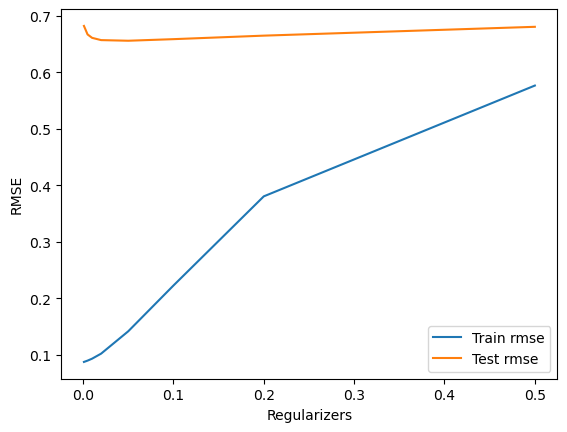

[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 5, 10, 100]

In [18]:
fig, ax = plt.subplots(1,1)

ax.plot(grid[], train_rmses[:8], label='Train rmse')
ax.plot(grid[:8], test_rmses[:8], label='Test rmse')
ax.set_xlabel('Regularizers')
ax.set_ylabel('RMSE')

ax.legend()
plt.show()

grid

In [131]:
best_rmse = np.min(test_rmses); best_rmse

0.6561024768356988

In [132]:
best_param = grid[np.argmin(test_rmses)]; best_param

(0.1, 0.1, 0.5, 0.01)

In [127]:
best_rmse = np.min(test_rmses); best_rmse

0.6585922638271475

In [129]:
best_param = grid[np.argmin(test_rmses)]; best_param

0.05

## Getting train and test error for different num of epochs

In [133]:
epochs = range(1, 251)
train_rmses = np.zeros(len(epochs))
test_rmses = np.zeros(len(epochs))
trainset_to_test = trainset.build_testset()
for i, n_epoch in enumerate(epochs):
    print(f"Number of epochs: {n_epoch}")
    svd_start_ts = time.time()
    svd = sp.SVD(
        n_factors=100, n_epochs=n_epoch, random_state=42,
        lr_all=0.01, reg_all=0.05,        
                )
    svd.fit(trainset)
    # Report train RMSE 
    train_preds = svd.test(trainset_to_test)
    rmse_train = sp.accuracy.rmse(train_preds)
    # Then report test RMSE
    predictions = svd.test(testset)
    rmse = sp.accuracy.rmse(predictions)
    print(f"RMSE of SVD: {rmse}")
    print(f"Took {time.time() - svd_start_ts} seconds.")
    test_rmses[i] = rmse
    train_rmses[i] = rmse_train

print(f"All test RMSEs: {test_rmses}")

Number of epochs: 1
RMSE: 0.7727
RMSE: 0.8051
RMSE of SVD: 0.8051452986883345
Took 0.22319698333740234 seconds.
Number of epochs: 2
RMSE: 0.7384
RMSE: 0.7883
RMSE of SVD: 0.7883316094884738
Took 0.30530500411987305 seconds.
Number of epochs: 3
RMSE: 0.7101
RMSE: 0.7754
RMSE of SVD: 0.7753729994669861
Took 0.23911476135253906 seconds.
Number of epochs: 4
RMSE: 0.6851
RMSE: 0.7645
RMSE of SVD: 0.7644999297604397
Took 0.32102203369140625 seconds.
Number of epochs: 5
RMSE: 0.6623
RMSE: 0.7550
RMSE of SVD: 0.7550243777198539
Took 0.2596871852874756 seconds.
Number of epochs: 6
RMSE: 0.6411
RMSE: 0.7466
RMSE of SVD: 0.7465880878527835
Took 0.2576572895050049 seconds.
Number of epochs: 7
RMSE: 0.6211
RMSE: 0.7390
RMSE of SVD: 0.738982499178977
Took 0.4117403030395508 seconds.
Number of epochs: 8
RMSE: 0.6020
RMSE: 0.7321
RMSE of SVD: 0.7320777957212655
Took 0.2816338539123535 seconds.
Number of epochs: 9
RMSE: 0.5837
RMSE: 0.7258
RMSE of SVD: 0.7257901965206195
Took 0.3576650619506836 seconds

RMSE: 0.1866
RMSE: 0.6623
RMSE of SVD: 0.6623071689555509
Took 0.7799458503723145 seconds.
Number of epochs: 76
RMSE: 0.1855
RMSE: 0.6622
RMSE of SVD: 0.6622096705180529
Took 0.7977349758148193 seconds.
Number of epochs: 77
RMSE: 0.1845
RMSE: 0.6621
RMSE of SVD: 0.6621150650719507
Took 0.8771200180053711 seconds.
Number of epochs: 78
RMSE: 0.1835
RMSE: 0.6620
RMSE of SVD: 0.6620232464929966
Took 0.8150649070739746 seconds.
Number of epochs: 79
RMSE: 0.1826
RMSE: 0.6619
RMSE of SVD: 0.661934113587805
Took 0.8384859561920166 seconds.
Number of epochs: 80
RMSE: 0.1817
RMSE: 0.6618
RMSE of SVD: 0.661847517726161
Took 0.9019358158111572 seconds.
Number of epochs: 81
RMSE: 0.1808
RMSE: 0.6618
RMSE of SVD: 0.661763398151432
Took 0.8371982574462891 seconds.
Number of epochs: 82
RMSE: 0.1799
RMSE: 0.6617
RMSE of SVD: 0.6616816170526026
Took 0.908994197845459 seconds.
Number of epochs: 83
RMSE: 0.1791
RMSE: 0.6616
RMSE of SVD: 0.6616021339600722
Took 0.8574540615081787 seconds.
Number of epochs:

RMSE: 0.1524
RMSE: 0.6591
RMSE of SVD: 0.6591480185673986
Took 1.4246492385864258 seconds.
Number of epochs: 149
RMSE: 0.1522
RMSE: 0.6591
RMSE of SVD: 0.6591325758811636
Took 1.3970627784729004 seconds.
Number of epochs: 150
RMSE: 0.1521
RMSE: 0.6591
RMSE of SVD: 0.6591174926740119
Took 1.515009880065918 seconds.
Number of epochs: 151
RMSE: 0.1519
RMSE: 0.6591
RMSE of SVD: 0.659102755208286
Took 1.426269292831421 seconds.
Number of epochs: 152
RMSE: 0.1517
RMSE: 0.6591
RMSE of SVD: 0.6590883321305633
Took 1.6082770824432373 seconds.
Number of epochs: 153
RMSE: 0.1515
RMSE: 0.6591
RMSE of SVD: 0.6590742459358556
Took 1.4897921085357666 seconds.
Number of epochs: 154
RMSE: 0.1513
RMSE: 0.6591
RMSE of SVD: 0.6590604892056963
Took 1.5458807945251465 seconds.
Number of epochs: 155
RMSE: 0.1512
RMSE: 0.6590
RMSE of SVD: 0.6590470547051837
Took 1.653252124786377 seconds.
Number of epochs: 156
RMSE: 0.1510
RMSE: 0.6590
RMSE of SVD: 0.6590339353860185
Took 1.4613661766052246 seconds.
Number of

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (250,) and (9,)

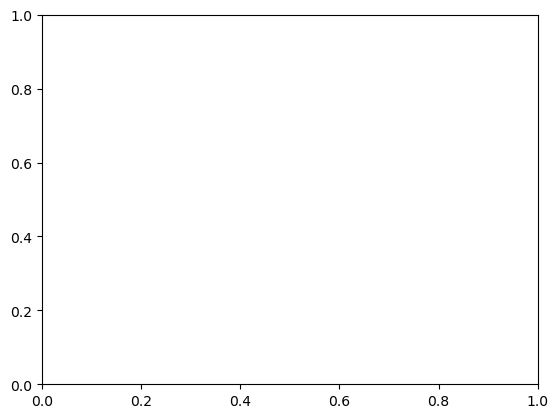

In [136]:
fig, ax = plt.subplots(1,1)

ax.plot(epochs, train_rmses, label='Train rmse')
ax.plot(epochs, test_rmses, label='Test rmse')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')

ax.legend()
plt.show()

## Training for many different dimensions

In [55]:
dimensions = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400]
train_rmses = np.zeros(len(dimensions))
test_rmses = np.zeros(len(dimensions))
trainset_to_test = trainset.build_testset()
for i, n_factor in enumerate(dimensions):
    print(f"Num features: {n_factor}")
    svd_start_ts = time.time()
    svd = sp.SVD(n_factors=n_factor, n_epochs=50)
    svd.fit(trainset)
    # Report train RMSE 
    train_preds = svd.test(trainset_to_test)
    rmse_train = sp.accuracy.rmse(train_preds)
    # Then report test RMSE
    predictions = svd.test(testset)
    rmse = sp.accuracy.rmse(predictions)
    print(f"RMSE of SVD: {rmse}")
    print(f"Took {time.time() - svd_start_ts} seconds.")
    test_rmses[i] = rmse
    train_rmses[i] = rmse_train

print(f"All test RMSEs: {test_rmses}")

Num features: 1
RMSE: 0.5586
RMSE: 0.6773
RMSE of SVD: 0.6773297186825369
Took 0.5489418506622314 seconds.
Num features: 10
RMSE: 0.4806
RMSE: 0.6734
RMSE of SVD: 0.6734411655777713
Took 0.3321061134338379 seconds.
Num features: 20
RMSE: 0.4365
RMSE: 0.6710
RMSE of SVD: 0.670961176849306
Took 1.944282054901123 seconds.
Num features: 30
RMSE: 0.3942
RMSE: 0.6769
RMSE of SVD: 0.6769142822664116
Took 0.6041898727416992 seconds.
Num features: 40
RMSE: 0.3700
RMSE: 0.6739
RMSE of SVD: 0.6739245852470429
Took 0.710284948348999 seconds.
Num features: 50
RMSE: 0.3410
RMSE: 0.6720
RMSE of SVD: 0.6719969497741214
Took 0.5037150382995605 seconds.
Num features: 60
RMSE: 0.3237
RMSE: 0.6728
RMSE of SVD: 0.6727970217223954
Took 0.43529772758483887 seconds.
Num features: 70
RMSE: 0.3089
RMSE: 0.6762
RMSE of SVD: 0.676212114236966
Took 0.519780158996582 seconds.
Num features: 80
RMSE: 0.2926
RMSE: 0.6784
RMSE of SVD: 0.6784009810357792
Took 0.4868490695953369 seconds.
Num features: 90
RMSE: 0.2792
RMS

In [56]:
test_rmses

array([0.67732972, 0.67344117, 0.67096118, 0.67691428, 0.67392459,
       0.67199695, 0.67279702, 0.67621211, 0.67840098, 0.67602317,
       0.67673239, 0.67846573, 0.68054573, 0.67979523, 0.68292832,
       0.68533196, 0.69401035])

In [57]:
train_rmses

array([0.55855046, 0.48057952, 0.43651077, 0.39424146, 0.3699818 ,
       0.34099951, 0.32371213, 0.30885224, 0.2925758 , 0.27918701,
       0.26635293, 0.22714574, 0.20162524, 0.18359041, 0.17134261,
       0.16156235, 0.15527591])

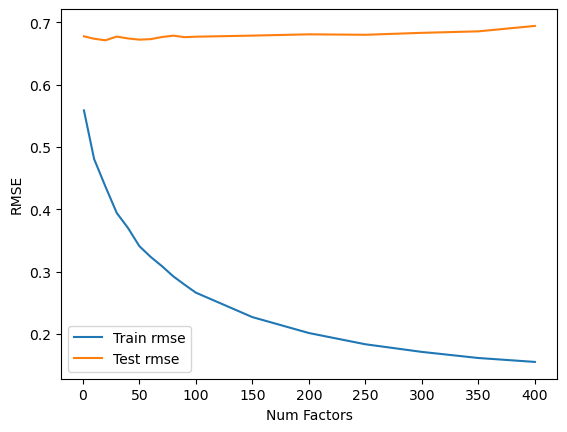

In [58]:
fig, ax = plt.subplots(1,1)

ax.plot(dimensions, train_rmses, label='Train rmse')
ax.plot(dimensions, test_rmses, label='Test rmse')
ax.set_xlabel('Num Factors')
ax.set_ylabel('RMSE')

ax.legend()
plt.show()

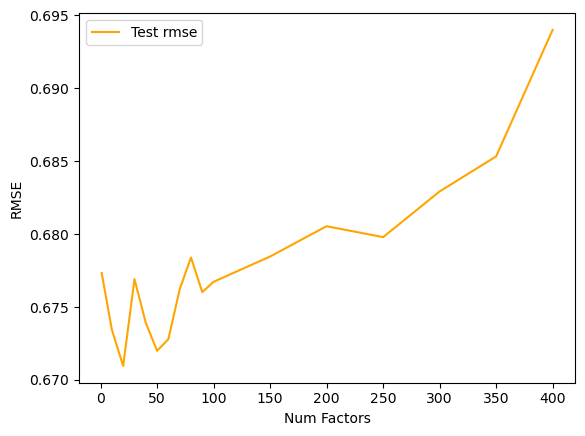

In [61]:
fig, ax = plt.subplots(1,1)

ax.plot(dimensions, test_rmses, label='Test rmse', color='orange')
ax.set_xlabel('Num Factors')
ax.set_ylabel('RMSE')

ax.legend()
plt.show()